In [7]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import seaborn as sns
sns.set(style="darkgrid")
from scipy import stats
import matplotlib.patches as mpatches

In [8]:
data_types = {'Recall Notification Date': str}
df = pd.read_csv("database.csv", dtype=data_types)

In [9]:
df.dtypes

Record ID                     int64
NHTSA Campaign               object
Manufacturer Campaign        object
Vehicle Make                 object
Vehicle Model                object
Model Year                    int64
Vehicle Manufacturer         object
Recall Type                  object
Recall Component             object
Manufacture Start Date      float64
Manufacture End Date        float64
Estimated Units             float64
Recall Initiative            object
Recall Manufacturer          object
Recall Notification Date     object
dtype: object

In [10]:
toyota_aliases = {
    'TOYOTA MOTOR CO., LTD.',
    'TOYOTA MOTOR NORTH AMERICA, INC.',
    'Toyota Motor Engineering & Manufacturing'
}

In [11]:
toyota_df = df.loc[df['Vehicle Manufacturer'].isin(toyota_aliases)]

In [12]:
toyota_df_over_500k = toyota_df.loc[df['Estimated Units'] > 500000.0]

In [13]:
len(toyota_df_over_500k)

527

In [14]:
toyota_df_filtered = toyota_df_over_500k.dropna(subset=['Recall Notification Date'])

In [15]:
toyota_df_filtered_with_date = toyota_df_filtered['Recall Notification Date'].apply(lambda x:pd.datetime.strptime(x, '%Y%m%d'))

In [16]:
type(toyota_df_filtered['Estimated Units'])

pandas.core.series.Series

In [17]:
date_split_value = pd.datetime(1995, 1, 1) # ignore values before 1995

In [18]:
recalls_by_units_df = pd.DataFrame({
        'Recall Notification Date': toyota_df_filtered_with_date,
        'Estimated Units': toyota_df_filtered['Estimated Units']
})

In [19]:
recalls_by_units_df_after_1995 = recalls_by_units_df.loc[recalls_by_units_df['Recall Notification Date'] > date_split_value]

In [20]:
recalls_by_unit_after_1995_unique = recalls_by_units_df_after_1995.drop_duplicates()

In [21]:
toyota_stock_data_types = {
    'Date': str,
    'Price': float
}
toyota_stock = pd.read_csv('zstock_data_clean/toyota_stock.txt', sep='\t', parse_dates=['Date'])

In [22]:
toyota_stock_after_1995 = toyota_stock.loc[toyota_stock['Date'] > date_split_value]

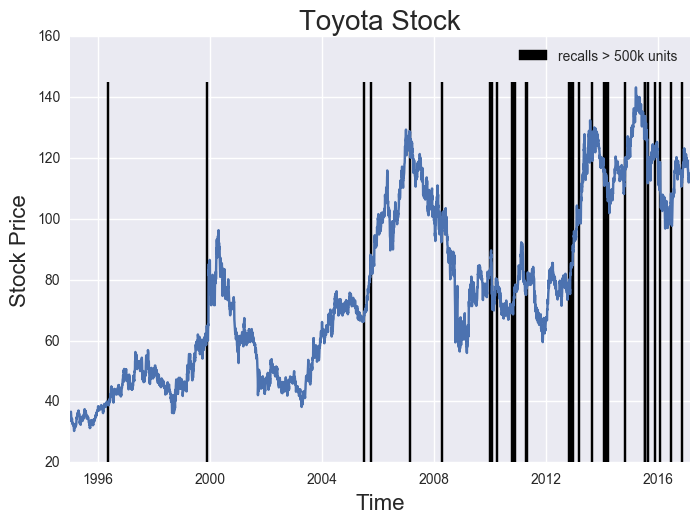

In [23]:
plt.plot(list(toyota_stock_after_1995['Date']), list(toyota_stock_after_1995['Price']))
#plt.scatter(list(recalls_by_unit_after_1995_unique['Recall Notification Date']), [25 for x in range(0, len(recalls_by_unit_after_1995_unique))])
#for i in range(0, len(recalls_by_unit_after_1995_unique))
#    plt.plot([, ])
my_dates_list = list(recalls_by_unit_after_1995_unique['Recall Notification Date'])
plt.vlines(x=my_dates_list, ymin=[20 for x in range(0, len(my_dates_list))], ymax=[145 for x in range(0, len(my_dates_list))])
plt.title('Toyota Stock', fontsize=20)
plt.xlabel('Time', fontsize=16)
plt.ylabel('Stock Price', fontsize=16)
black_patch = mpatches.Patch(color='black', label='recalls > 500k units')
plt.legend(handles=[black_patch],
           loc='upper right')
plt.show()

In [24]:
type(toyota_stock_after_1995['Date'][5707])

pandas.tslib.Timestamp

In [25]:
toyota_stock_after_1995_reset_indices = toyota_stock_after_1995.reset_index()
toyota_stock_after_1995_reset_indices.drop('index', axis=1, inplace=True)

In [26]:
# now we will conduct the event study
dates_arr = np.array(toyota_stock_after_1995_reset_indices['Date'])
prices_arr = np.array(toyota_stock_after_1995_reset_indices['Price'])
recalls_dates_arr = np.array(recalls_by_unit_after_1995_unique['Recall Notification Date'])

In [27]:
len(dates_arr)

5577

In [28]:
len(recalls_dates_arr)

30

In [29]:
recalls_dates_arr.sort()
recalls_dates_arr_last_five_dates_removed = recalls_dates_arr[1:-8]
recalls_dates_arr_last_five_dates_removed

array(['1999-11-30T00:00:00.000000000', '2005-07-05T00:00:00.000000000',
       '2005-10-05T00:00:00.000000000', '2007-02-28T00:00:00.000000000',
       '2008-04-16T00:00:00.000000000', '2009-12-31T00:00:00.000000000',
       '2010-02-05T00:00:00.000000000', '2010-03-30T00:00:00.000000000',
       '2010-10-12T00:00:00.000000000', '2010-11-15T00:00:00.000000000',
       '2010-11-29T00:00:00.000000000', '2011-04-13T00:00:00.000000000',
       '2011-05-06T00:00:00.000000000', '2012-11-05T00:00:00.000000000',
       '2012-11-30T00:00:00.000000000', '2012-12-20T00:00:00.000000000',
       '2013-03-13T00:00:00.000000000', '2013-08-27T00:00:00.000000000',
       '2014-02-05T00:00:00.000000000', '2014-02-27T00:00:00.000000000',
       '2014-03-21T00:00:00.000000000'], dtype='datetime64[ns]')

In [43]:
estimation_window = 30
event_window = 30

In [44]:
import event_study.event_study as evt

In [45]:
t_statistic, stdev, caar, car, abnormal_returns, bases = evt.event_study(stock_date_data=dates_arr,
                                                                           stock_price_data=prices_arr,
                                                                           event_dates=recalls_dates_arr_last_five_dates_removed,
                                                                           estimation_window=estimation_window,
                                                                           event_window=event_window)
print("t stat:", t_statistic)
print("stdev: ", stdev)

t stat: 1.23063250313
stdev:  0.104104004352


In [46]:
import random as random

In [47]:
def generate_random_dates(number_of_random_numbers):
    number_of_random_numbers = 30
    randoms = set()
    for i in range(0, number_of_random_numbers):
        r = random.randrange(0, len(toyota_stock_after_1995_reset_indices))
        while r < event_window or r > len(toyota_stock_after_1995_reset_indices) - event_window:
            r = random.randrange(0, len(toyota_stock_after_1995_reset_indices))
        randoms.add(r)
    random_dates_series = toyota_stock_after_1995_reset_indices['Date'][randoms]
    random_dates = [np.datetime64(the_date) for the_date in list(random_dates_series)]
    random_dates = np.array(random_dates)
    return random_dates

In [48]:
n_random_numbers = 30
random_dates = generate_random_dates(n_random_numbers)

In [49]:
def simulate_event_study(num_simulations, est_win, evt_win):
    t_statistics = []
    p_values = []
    for i in range(0, num_simulations):
        random_dates = generate_random_dates(30)
        t_stat, stdev, caar, car, abnormal_returns, bases = evt.event_study(stock_date_data=dates_arr,
                                                                               stock_price_data=prices_arr,
                                                                               event_dates=random_dates,
                                                                               estimation_window=est_win,
                                                                               event_window=evt_win)
        t_statistics.append(t_stat)
        p_value = stats.t.cdf(x=t_stat, df=len(random_dates)-1)
        p_values.append(p_value)
    return t_statistics, p_values

In [50]:
import scipy.stats as stats

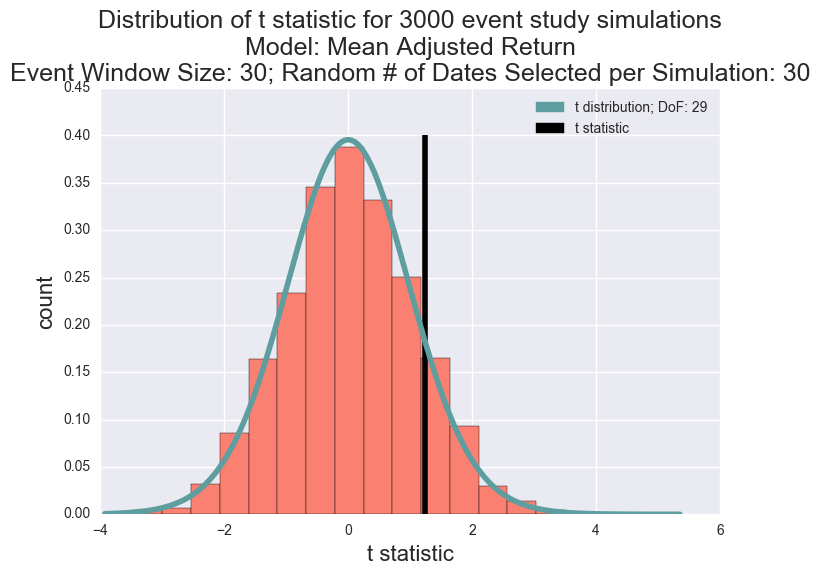

In [51]:
# simulate the t statistic
n_simulations = 3000
t_stats, p_vals = simulate_event_study(n_simulations, est_win=estimation_window, evt_win=event_window)

DoF = len(random_dates) - 1
x = np.linspace(min(t_stats), max(t_stats), 200)
y = stats.t.pdf(x, DoF)

t_curve_color = 'cadetblue'
line_color = 'black'

plt.plot(x, y, c=t_curve_color, linewidth=4)

plt.vlines(x=t_statistic, ymin=0, ymax=0.4, linewidth=4)

plt.hist(t_stats, bins=20, normed=True, color='salmon')
plt.title('Distribution of t statistic for {:d} event study simulations\nModel: Mean Adjusted Return\nEvent Window Size: {:2d}; Random # of Dates Selected per Simulation: {:d}'.format(n_simulations, event_window, len(random_dates)), fontsize=18)
plt.ylabel('count', fontsize=16)
plt.xlabel('t statistic', fontsize=16)

t_curve_patch = mpatches.Patch(color=t_curve_color, label='t distribution; DoF: {:d}'.format(DoF))
t_statistic_line_patch = mpatches.Patch(color=line_color, label='t statistic')

plt.legend(handles=[t_curve_patch, t_statistic_line_patch],
           loc='upper right')

plt.show()

In [52]:
sorted_t_statistics = sorted(t_stats)
n_elems_less_than_t_stat = len([x for x in sorted_t_statistics if x < t_statistic])
pr_less_than_t_stat = n_elems_less_than_t_stat / n_simulations
pr_less_than_t_stat

0.866

In [53]:
n_simulations = 100
t_stats_over_evt_win = []
the_range = range(10, 30, 3)
for window in the_range:
    the_t_statistic, stdev, caar, car, abnormal_returns, bases = evt.event_study(stock_date_data=dates_arr,
                                                                           stock_price_data=prices_arr,
                                                                           event_dates=recalls_dates_arr_last_five_dates_removed,
                                                                           estimation_window=window,
                                                                           event_window=window)
    the_t_statistics, the_p_values = simulate_event_study(n_simulations, est_win=window, evt_win=window)
    the_sorted_t_stats = sorted(the_t_statistics)
    the_n_elems_less_than_t_stat = len([x for x in the_sorted_t_stats if x < the_t_statistic])
    pr_less_than_t_stat = the_n_elems_less_than_t_stat / n_simulations
    t_stats_over_evt_win.append(pr_less_than_t_stat)

In [54]:
t_stats_over_evt_win

[0.94, 0.98, 0.89, 0.9, 0.86, 0.67, 0.85]

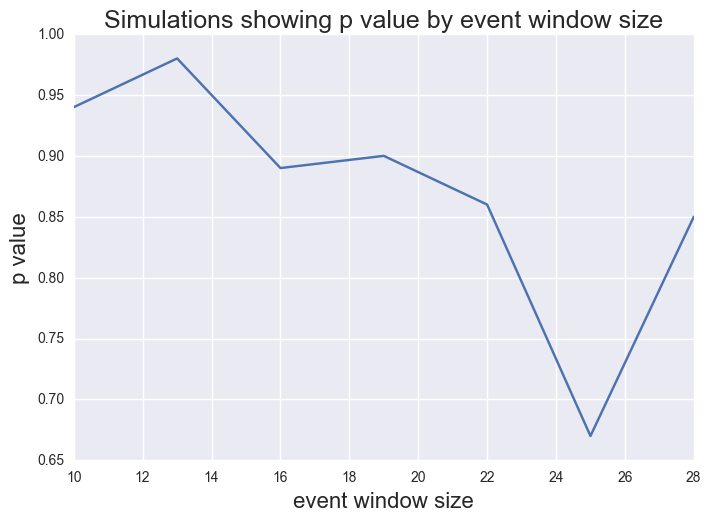

In [55]:
plt.plot(the_range, t_stats_over_evt_win)
plt.title('Simulations showing p value by event window size', fontsize=18)
plt.xlabel('event window size', fontsize=16)
plt.ylabel('p value', fontsize=16)
plt.xlim((min(the_range), max(the_range)))
plt.show()